In [1]:
pip install --upgrade scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import time
import random
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# TensorFlow (if needed)
import tensorflow as tf

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, precision_recall_curve, roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

# Imbalanced-learn
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.metrics import classification_report_imbalanced

# Collections
from collections import Counter


In [ ]:
df = pd.read_csv('/kaggle/input/credit-card/creditcard.csv')

In [4]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [6]:
# Data Spliting

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

# Use train_test_split for splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the Distribution of the labels
print('-' * 100)
print('Original dataset shape %s' % Counter(y))
print('Training dataset shape %s' % Counter(y_train))
print('Testing dataset shape %s' % Counter(y_test))

# Turn into an array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

original_Xtrain = X_train
original_Xtest = X_test
original_ytrain = y_train
original_ytest = y_test

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label / len(y_train))
print(test_counts_label / len(y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Original dataset shape Counter({0: 284315, 1: 492})
Training dataset shape Counter({0: 227451, 1: 394})
Testing dataset shape Counter({0: 56864, 1: 98})
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


# **MLP_Model** 

In [7]:
# --- MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.block1 = nn.Sequential(
            nn.BatchNorm1d(self.input_dim),
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU()
        )

        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.BatchNorm1d(self.hidden_dim),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU()
            ) for _ in range(self.num_layers)
        ])

        self.output_block = nn.Sequential(
            nn.BatchNorm1d(self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_dim)
        )

        self.layers = nn.ModuleList([self.block1] + list(self.blocks) + [self.output_block])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.view(-1)

#  Training Model Without Oversampling technique

In [10]:

#  1. Dataset split
X_train_main, X_val, y_train_main, y_val = train_test_split(
    original_Xtrain, original_ytrain, test_size=0.2, random_state=42, stratify=original_ytrain
)


In [11]:

#  2. Dataset wrapper
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

In [12]:

# 3. Dataloaders
batch_size = 256
train_loader = DataLoader(MyDataset(X_train_main, y_train_main), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MyDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(MyDataset(original_Xtest, original_ytest), batch_size=batch_size, shuffle=False)

In [ ]:
#4. Hyperparameters

input_dim = original_Xtrain.shape[1]
output_dim = 1
hidden_dim = 64
num_layers = 2
batch_size = 512

In [ ]:
#  5. Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=original_Xtrain.shape[1], output_dim=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

Epoch [1/100] | Train Loss: 0.0006 | Train F1: 0.9565 | Val Loss: 0.0061 | Val F1: 0.8000
Epoch [11/100] | Train Loss: 0.0005 | Train F1: 0.9421 | Val Loss: 0.0067 | Val F1: 0.7770
Epoch [21/100] | Train Loss: 0.0005 | Train F1: 0.9582 | Val Loss: 0.0070 | Val F1: 0.8000
Epoch [31/100] | Train Loss: 0.0002 | Train F1: 0.9761 | Val Loss: 0.0067 | Val F1: 0.7832
Epoch [41/100] | Train Loss: 0.0003 | Train F1: 0.9696 | Val Loss: 0.0076 | Val F1: 0.7832
Epoch [51/100] | Train Loss: 0.0003 | Train F1: 0.9744 | Val Loss: 0.0077 | Val F1: 0.7941
Epoch [61/100] | Train Loss: 0.0003 | Train F1: 0.9713 | Val Loss: 0.0072 | Val F1: 0.8112
Epoch [71/100] | Train Loss: 0.0003 | Train F1: 0.9729 | Val Loss: 0.0084 | Val F1: 0.8058
Epoch [81/100] | Train Loss: 0.0003 | Train F1: 0.9712 | Val Loss: 0.0073 | Val F1: 0.8028
Epoch [91/100] | Train Loss: 0.0003 | Train F1: 0.9696 | Val Loss: 0.0081 | Val F1: 0.8029


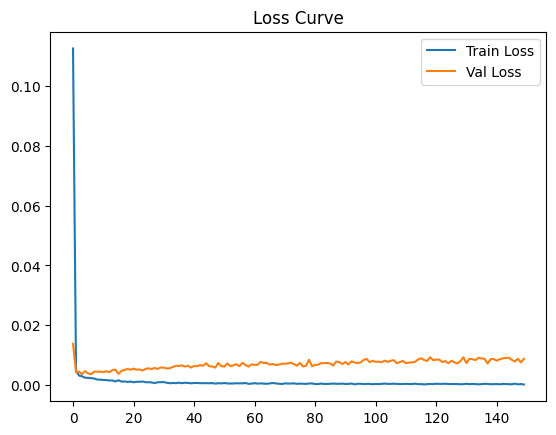

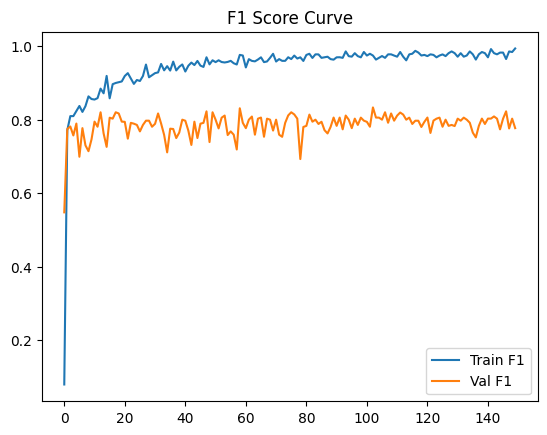


--- Test Set Evaluation ---
Accuracy: 0.9995
F1 Score: 0.8478
Precision: 0.9070
Recall: 0.7959
ROC-AUC: 0.9403

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.91      0.80      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



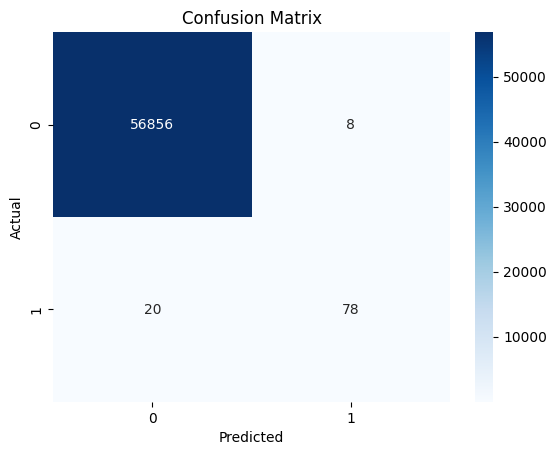

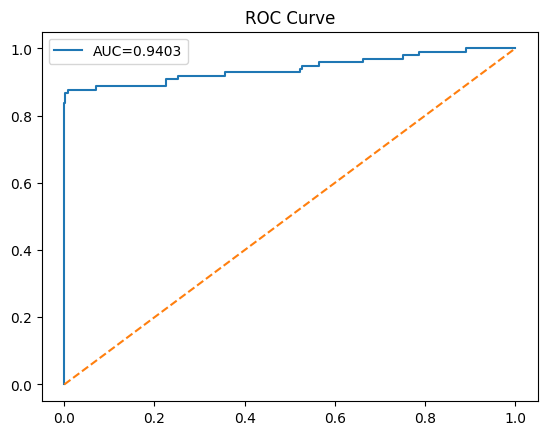

In [20]:
# 6. Training Loop
for epoch in range(epochs):
    # --- Training ---
    model.train()
    train_loss, preds, labels = 0, [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds += (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int).tolist()
        labels += y_batch.cpu().numpy().tolist()
    train_losses.append(train_loss / len(train_loader))
    train_f1s.append(f1_score(labels, preds))

    # --- Validation ---
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_preds += (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int).tolist()
            val_labels += y_batch.cpu().numpy().tolist()
    val_losses.append(val_loss / len(val_loader))
    val_f1s.append(f1_score(val_labels, val_preds))

    if epoch % 10==0:

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_losses[-1]:.4f} | Train F1: {train_f1s[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val F1: {val_f1s[-1]:.4f}")

# 7. Training Curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.legend(); plt.title("F1 Score Curve"); plt.show()

#  8. Test Evaluation
model.eval()
test_preds, test_labels, test_probs = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        test_probs += probs.tolist()
        test_preds += preds.tolist()
        test_labels += y_batch.numpy().tolist()

#  9. Test Metrics
print("\n--- Test Set Evaluation ---")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"F1 Score: {f1_score(test_labels, test_preds):.4f}")
print(f"Precision: {precision_score(test_labels, test_preds):.4f}")
print(f"Recall: {recall_score(test_labels, test_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(test_labels, test_probs):.4f}")
print("\nClassification Report:\n", classification_report(test_labels, test_preds))

#  10. Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# 11. ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.4f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curve"); plt.show()


 # With Oversampling technique(Smote)

In [17]:
# Hyperparameters
# -------------------
input_dim = original_Xtrain.shape[1]
output_dim = 1
hidden_dim = 64
num_layers = 2
batch_size = 512
lr = 0.001
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



--- Fold 1 ---
Epoch 1/100 | Train Loss: 0.0386 | Train F1: 0.9870 | Val Loss: 0.0137 | Val F1: 0.4099
Epoch 11/100 | Train Loss: 0.0017 | Train F1: 0.9995 | Val Loss: 0.0061 | Val F1: 0.7303
Epoch 21/100 | Train Loss: 0.0013 | Train F1: 0.9996 | Val Loss: 0.0067 | Val F1: 0.7251
Epoch 31/100 | Train Loss: 0.0006 | Train F1: 0.9998 | Val Loss: 0.0060 | Val F1: 0.7425
Epoch 41/100 | Train Loss: 0.0005 | Train F1: 0.9999 | Val Loss: 0.0071 | Val F1: 0.7458
Epoch 51/100 | Train Loss: 0.0003 | Train F1: 0.9999 | Val Loss: 0.0078 | Val F1: 0.7602
Epoch 61/100 | Train Loss: 0.0003 | Train F1: 0.9999 | Val Loss: 0.0076 | Val F1: 0.7730
Epoch 71/100 | Train Loss: 0.0004 | Train F1: 0.9999 | Val Loss: 0.0079 | Val F1: 0.7898
Epoch 81/100 | Train Loss: 0.0003 | Train F1: 0.9999 | Val Loss: 0.0084 | Val F1: 0.7811
Epoch 91/100 | Train Loss: 0.0003 | Train F1: 0.9999 | Val Loss: 0.0084 | Val F1: 0.7975

--- Fold 2 ---
Epoch 1/100 | Train Loss: 0.0353 | Train F1: 0.9884 | Val Loss: 0.0087 | Val F1

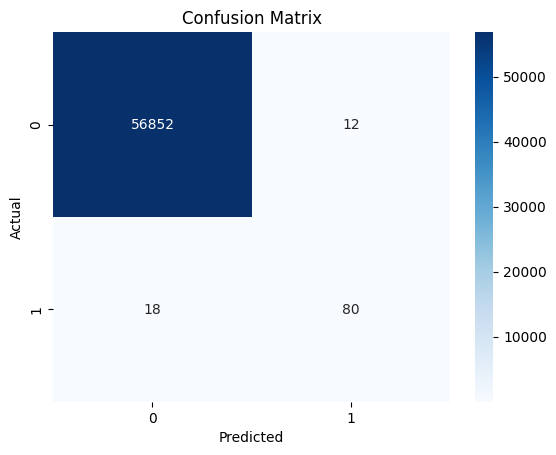

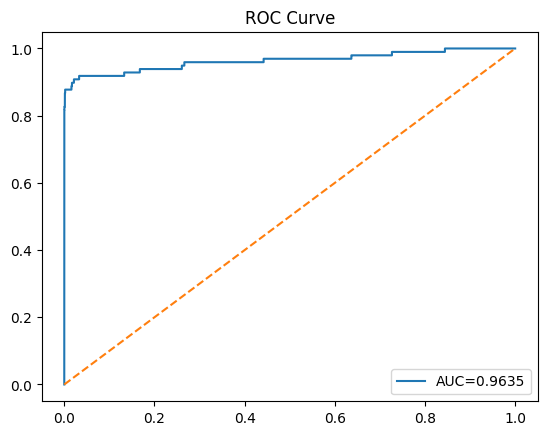

In [24]:
# -------------------
# Cross-Validation with SMOTE
# -------------------
accuracy_lst, precision_lst, recall_lst, f1_lst, auc_lst = [], [], [], [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(original_Xtrain, original_ytrain), 1):
    print(f"\n--- Fold {fold} ---")

    # Split folds
    X_train_fold, y_train_fold = original_Xtrain[train_idx], original_ytrain[train_idx]
    X_val_fold, y_val_fold = original_Xtrain[val_idx], original_ytrain[val_idx]

    # Apply SMOTE on training fold only
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_fold, y_train_fold)

    # Create DataLoader for oversampled data
    train_loader = DataLoader(MyDataset(X_train_res, y_train_res), batch_size=batch_size, shuffle=True)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)

    # Model, Loss, Optimizer
    model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Track losses and F1
    train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        preds, labels = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds += (torch.sigmoid(logits).detach().cpu().numpy() > 0.5).astype(int).tolist()
            labels += yb.cpu().numpy().tolist()

        # Store training metrics
        train_f1_epoch = f1_score(labels, preds)
        train_f1_scores.append(train_f1_epoch)
        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_tensor).cpu()
            val_probs = torch.sigmoid(val_logits).numpy()
            val_preds = (val_probs > 0.5).astype(int)

        val_f1_epoch = f1_score(y_val_fold, val_preds)
        val_f1_scores.append(val_f1_epoch)
        val_loss = nn.BCELoss()(torch.tensor(val_probs), torch.tensor(y_val_fold, dtype=torch.float32)).item()
        val_losses.append(val_loss)

        # Logging every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_losses[-1]:.4f} | "
                  f"Train F1: {train_f1_scores[-1]:.4f} | "
                  f"Val Loss: {val_losses[-1]:.4f} | "
                  f"Val F1: {val_f1_scores[-1]:.4f}")

    # Store fold metrics
    accuracy_lst.append(accuracy_score(y_val_fold, val_preds))
    precision_lst.append(precision_score(y_val_fold, val_preds))
    recall_lst.append(recall_score(y_val_fold, val_preds))
    f1_lst.append(val_f1_scores[-1])
    auc_lst.append(roc_auc_score(y_val_fold, val_probs))

# -------------------
# CV Summary
# -------------------
print("\n--- Cross-Validation Results ---")
print(f"Accuracy: {np.mean(accuracy_lst):.4f}")
print(f"Precision: {np.mean(precision_lst):.4f}")
print(f"Recall: {np.mean(recall_lst):.4f}")
print(f"F1 Score: {np.mean(f1_lst):.4f}")
print(f"ROC-AUC: {np.mean(auc_lst):.4f}")

# -------------------
# Final Training on Full SMOTE Data
# -------------------
Xsm_train, ysm_train = SMOTE(random_state=42).fit_resample(original_Xtrain, original_ytrain)
train_loader = DataLoader(MyDataset(Xsm_train, ysm_train), batch_size=batch_size, shuffle=True)

model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

start = time.time()
model.train()
final_train_losses, final_train_f1 = [], []

for epoch in range(epochs):
    epoch_loss = 0
    preds, labels = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds += (torch.sigmoid(logits).detach().cpu().numpy() > 0.5).astype(int).tolist()
        labels += yb.cpu().numpy().tolist()

    # Track metrics
    epoch_f1 = f1_score(labels, preds)
    final_train_losses.append(epoch_loss / len(train_loader))
    final_train_f1.append(epoch_f1)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {final_train_losses[-1]:.4f} | Train F1: {final_train_f1[-1]:.4f}")

end = time.time()
print(f"\nFinal model training took {end - start:.2f} seconds")

# -------------------
# Final Test Evaluation
# -------------------
X_test_tensor = torch.tensor(original_Xtest, dtype=torch.float32).to(device)
y_test_true = original_ytest

model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor).cpu()
    test_probs = torch.sigmoid(test_logits).numpy()
    test_preds = (test_probs > 0.5).astype(int)

# Metrics
print("\n--- Final Test Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test_true, test_preds):.4f}")
print(f"F1 Score: {f1_score(y_test_true, test_preds):.4f}")
print(f"Precision: {precision_score(y_test_true, test_preds):.4f}")
print(f"Recall: {recall_score(y_test_true, test_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_true, test_probs):.4f}")
print("\nClassification Report:\n", classification_report(y_test_true, test_preds))

# Confusion Matrix
cm = confusion_matrix(y_test_true, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_true, test_probs)
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.4f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curve"); plt.show()


# With Oversampling technique SVMSMOTE

In [31]:
# -------------------
# Cross-Validation with SVMSMOTE
# -------------------
accuracy_lst, precision_lst, recall_lst, f1_lst, auc_lst = [], [], [], [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(original_Xtrain, original_ytrain), 1):
    print(f"\n--- Fold {fold} ---")

    # Split folds
    X_train_fold, y_train_fold = original_Xtrain[train_idx], original_ytrain[train_idx]
    X_val_fold, y_val_fold = original_Xtrain[val_idx], original_ytrain[val_idx]

    # Apply SVMSMOTE on training fold only
    sm = SVMSMOTE(random_state=42, k_neighbors=5, m_neighbors=10)
    X_train_res, y_train_res = sm.fit_resample(X_train_fold, y_train_fold)

    # Dataloader
    train_loader = DataLoader(MyDataset(X_train_res, y_train_res), batch_size=batch_size, shuffle=True)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)

    # Model, Loss, Optimizer
    model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Track metrics
    train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss, preds, labels = 0, [], []

        # Training batches
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds += (torch.sigmoid(logits).detach().cpu().numpy() > 0.5).astype(int).tolist()
            labels += yb.cpu().numpy().tolist()

        # Store training metrics
        train_losses.append(epoch_loss / len(train_loader))
        train_f1_scores.append(f1_score(labels, preds))

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_tensor).cpu()
            val_probs = torch.sigmoid(val_logits).numpy()
            val_preds = (val_probs > 0.5).astype(int)

        val_f1_epoch = f1_score(y_val_fold, val_preds)
        val_f1_scores.append(val_f1_epoch)
        val_loss = nn.BCELoss()(torch.tensor(val_probs), torch.tensor(y_val_fold, dtype=torch.float32)).item()
        val_losses.append(val_loss)

        # Logging every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_losses[-1]:.4f} | "
                  f"Train F1: {train_f1_scores[-1]:.4f} | "
                  f"Val Loss: {val_losses[-1]:.4f} | "
                  f"Val F1: {val_f1_scores[-1]:.4f}")

    # Store fold metrics
    accuracy_lst.append(accuracy_score(y_val_fold, val_preds))
    precision_lst.append(precision_score(y_val_fold, val_preds))
    recall_lst.append(recall_score(y_val_fold, val_preds))
    f1_lst.append(val_f1_scores[-1])
    auc_lst.append(roc_auc_score(y_val_fold, val_probs))

# -------------------
# CV Summary
# -------------------
print("\n--- Cross-Validation Results (SVMSMOTE) ---")
print(f"Accuracy: {np.mean(accuracy_lst):.4f}")
print(f"Precision: {np.mean(precision_lst):.4f}")
print(f"Recall: {np.mean(recall_lst):.4f}")
print(f"F1 Score: {np.mean(f1_lst):.4f}")
print(f"ROC-AUC: {np.mean(auc_lst):.4f}")



--- Fold 1 ---
Epoch 1/100 | Train Loss: 0.0237 | Train F1: 0.9931 | Val Loss: 0.0096 | Val F1: 0.5095
Epoch 11/100 | Train Loss: 0.0011 | Train F1: 0.9998 | Val Loss: 0.0054 | Val F1: 0.7625
Epoch 21/100 | Train Loss: 0.0008 | Train F1: 0.9998 | Val Loss: 0.0085 | Val F1: 0.8322
Epoch 31/100 | Train Loss: 0.0005 | Train F1: 0.9999 | Val Loss: 0.0121 | Val F1: 0.7619
Epoch 41/100 | Train Loss: 0.0005 | Train F1: 0.9999 | Val Loss: 0.0072 | Val F1: 0.8258
Epoch 51/100 | Train Loss: 0.0004 | Train F1: 0.9999 | Val Loss: 0.0139 | Val F1: 0.7758
Epoch 61/100 | Train Loss: 0.0002 | Train F1: 0.9999 | Val Loss: 0.0093 | Val F1: 0.8421
Epoch 71/100 | Train Loss: 0.0002 | Train F1: 1.0000 | Val Loss: 0.0076 | Val F1: 0.8421
Epoch 81/100 | Train Loss: 0.0002 | Train F1: 0.9999 | Val Loss: 0.0103 | Val F1: 0.8176
Epoch 91/100 | Train Loss: 0.0001 | Train F1: 1.0000 | Val Loss: 0.0135 | Val F1: 0.8312

--- Fold 2 ---
Epoch 1/100 | Train Loss: 0.0219 | Train F1: 0.9937 | Val Loss: 0.0054 | Val F1

Epoch 1/100 | Train Loss: 0.0171
Epoch 2/100 | Train Loss: 0.0034
Epoch 3/100 | Train Loss: 0.0025
Epoch 4/100 | Train Loss: 0.0024
Epoch 5/100 | Train Loss: 0.0018
Epoch 6/100 | Train Loss: 0.0017
Epoch 7/100 | Train Loss: 0.0015
Epoch 8/100 | Train Loss: 0.0014
Epoch 9/100 | Train Loss: 0.0014
Epoch 10/100 | Train Loss: 0.0012
Epoch 11/100 | Train Loss: 0.0013
Epoch 12/100 | Train Loss: 0.0012
Epoch 13/100 | Train Loss: 0.0012
Epoch 14/100 | Train Loss: 0.0009
Epoch 15/100 | Train Loss: 0.0009
Epoch 16/100 | Train Loss: 0.0010
Epoch 17/100 | Train Loss: 0.0010
Epoch 18/100 | Train Loss: 0.0007
Epoch 19/100 | Train Loss: 0.0010
Epoch 20/100 | Train Loss: 0.0009
Epoch 21/100 | Train Loss: 0.0008
Epoch 22/100 | Train Loss: 0.0006
Epoch 23/100 | Train Loss: 0.0007
Epoch 24/100 | Train Loss: 0.0007
Epoch 25/100 | Train Loss: 0.0005
Epoch 26/100 | Train Loss: 0.0008
Epoch 27/100 | Train Loss: 0.0007
Epoch 28/100 | Train Loss: 0.0008
Epoch 29/100 | Train Loss: 0.0005
Epoch 30/100 | Train Lo

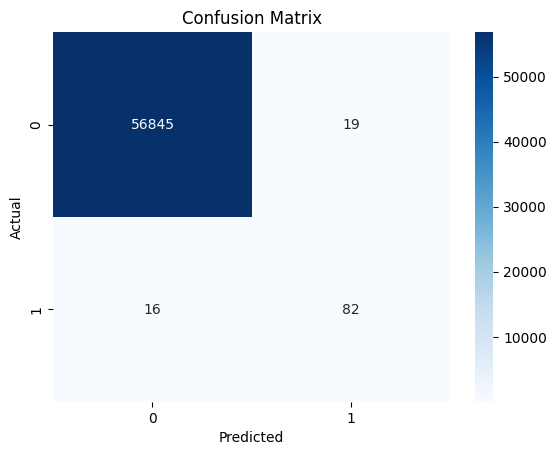

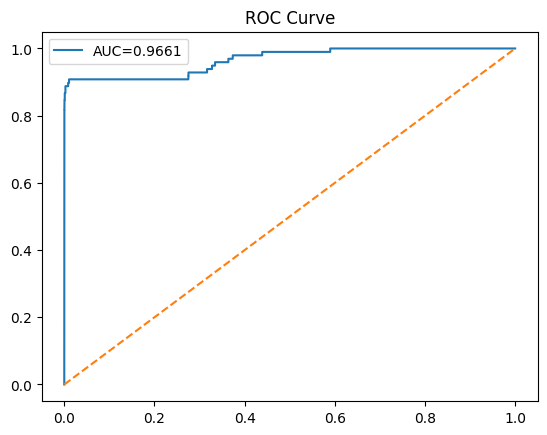

In [33]:


# -------------------
# Final Training on Full SVMSMOTE Data
# -------------------
Xsm_train, ysm_train = SVMSMOTE(random_state=42, k_neighbors=5, m_neighbors=10).fit_resample(original_Xtrain, original_ytrain)
train_loader = DataLoader(MyDataset(Xsm_train, ysm_train), batch_size=batch_size, shuffle=True)

model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

start = time.time()
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss / len(train_loader):.4f}")
end = time.time()
print(f"\nFinal model training took {end - start:.2f} seconds")

# -------------------
# Final Test Evaluation
# -------------------
X_test_tensor = torch.tensor(original_Xtest, dtype=torch.float32).to(device)
y_test_true = original_ytest

model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor).cpu()
    test_probs = torch.sigmoid(test_logits).numpy()
    test_preds = (test_probs > 0.5).astype(int)

# Metrics
print("\n--- Final Test Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test_true, test_preds):.4f}")
print(f"F1 Score: {f1_score(y_test_true, test_preds):.4f}")
print(f"Precision: {precision_score(y_test_true, test_preds):.4f}")
print(f"Recall: {recall_score(y_test_true, test_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_true, test_probs):.4f}")
print("\nClassification Report:\n", classification_report(y_test_true, test_preds))

# Confusion Matrix
cm = confusion_matrix(y_test_true, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_true, test_probs)
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.4f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curve"); plt.show()
